# Labor Market Projection Data

In [22]:
# Data science libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Local modules
import scripts.cccco as cccco
import scripts.labor_market as labor_market
import scripts.join_tools as join_tools

In [2]:
all_colleges = cccco.get_ccc_colleges()

The issue here is that labor market data is indexed by **Standard Occupation Classification** (SOC) Codes, while college programs are indexed by **Taxonomy of Program** (TOP) Codes and by **Classification of Instructional Programs** (CIP) Codes.  The match between these is not one-to-one.

TOP Codes do not appear to be listed in .csv or .xlsx form anywhere I can think to look, but they are indirectly present in the TOP-CIP crosswalk (`./resources/TOPCIPJune26.xlsx`). Active TOP Codes can also be mined from DataMart.

Annoyingly, there is not crosswalk between TOP Codes and SOC Codes, so we'll have to map from TOP to CIP to SOC. Alternatively, we can try fuzzy joins between TOP Code Descriptions (scraped from DataMart) and SOC Code Descriptions (`./resources/soc_2018_definitions.xlsx`).

First, add the Metropolitan Statistical Area to which the college belongs to the college dataset:

In [3]:
# Gather all Metropolitan Statistical Area (MSA) data. This will allow us to
# join labor market data to the college data.

msa = labor_market.get_labor_market_msa_data()
print(f"{msa.shape[0]:,} rows")
msa.head()

29 rows


,Area Name,Metropolitan Statistical Area,MSA Counties
0,Redding MSA (Shasta County),Redding MSA,Shasta County
1,Oakland-Hayward-Berkeley MD (Alameda and Contr...,Oakland-Hayward-Berkeley MD,Alameda and Contra Costa Counties
2,Fresno MSA (Fresno County),Fresno MSA,Fresno County
3,San Jose-Sunnyvale-Santa Clara MSA (San Benito...,San Jose-Sunnyvale-Santa Clara MSA,San Benito and Santa Clara Counties
4,Riverside-San Bernardino-Ontario MSA (Riversid...,Riverside-San Bernardino-Ontario MSA,Riverside and San Bernardino Counties


In [4]:
# Add MSA data to `all_colleges` dataset
area_counties = msa["MSA Counties"].dropna().unique()

all_colleges["Matched Counties"] = all_colleges["County"].apply(
    lambda x: join_tools.get_best_match(x, area_counties)
)

# One row per college per program
all_colleges = pd.merge(
    all_colleges,
    msa,
    left_on="Matched Counties",
    right_on="MSA Counties",
    how="left"
)

print(f"{all_colleges.shape[0]:,} rows")
all_colleges.head()

115 rows


,CollegeID,CollegeName,DistrictID,StreetAddress,City,County,Zip,ZipPlus4,MailingAddress,MailingCity,...,Phone,WebsiteURL,Latitude,Longitude,LogoURL,District,Matched Counties,Area Name,Metropolitan Statistical Area,MSA Counties
0,021,Cuyamaca College,020,900 Rancho San Diego Parkway,El Cajon,San Diego,92019,4304,900 Rancho San Diego Parkway,El Cajon,...,619.660.4000,www.cuyamaca.edu,32.744890,-116.935229,CuyamacaCollegeLogo.jpg,None,San Diego County,San Diego-Carlsbad MSA (San Diego County),San Diego-Carlsbad MSA,San Diego County
1,022,Grossmont College,020,8800 Grossmont College Drive,El Cajon,San Diego,92020,1799,8800 Grossmont College Drive,El Cajon,...,619.644.7000,www.grossmont.edu,32.817897,-117.005640,GrossmontCollegelogo.jpg,None,San Diego County,San Diego-Carlsbad MSA (San Diego County),San Diego-Carlsbad MSA,San Diego County
2,031,Imperial Valley College,030,380 East Aten Road,Imperial,Imperial,92251,9787,380 East Aten Road,Imperial,...,760.352.8320,www.imperial.edu,32.825859,-115.502999,ImperialValleyCollegeLogocopy.jpg,None,Imperial County,El Centro MSA (Imperial County),El Centro MSA,Imperial County
3,051,MiraCosta College,050,1 Barnard Drive,Oceanside,San Diego,92056,3899,1 Barnard Drive,Oceanside,...,760.757.2121,www.miracosta.edu,33.188864,-117.301064,Mira_Costa_College_Logo_4c.png,None,San Diego County,San Diego-Carlsbad MSA (San Diego County),San Diego-Carlsbad MSA,San Diego County
4,061,Palomar College,060,1140 West Mission Road,San Marcos,San Diego,92069,1487,1140 West Mission Road,San Marcos,...,760.744.1150,www.palomar.edu,33.147015,-117.183980,PalomarCollegeLogo.jpg,None,San Diego County,San Diego-Carlsbad MSA (San Diego County),San Diego-Carlsbad MSA,San Diego County


Next, we can join relevant labor market data by matching the TOP Code from the college data set to the SOC Code from the labor market data set. Since this is a one-to-many match, we won't do this at the DataFrame level.

Instead, we can perhaps consider the following use case:

1. User selects a job of interest (e.g., "Data Science").
2. We locate the relevant SOC Code data from labor market data set.
3. Rank MSA's by growth in that field (by percent growth or numeric?)
4. Report the colleges in the MSA with the top growth and add programs with corresponding TOP Codes.

In [5]:
# Step 1, 2, and 3:

occupation = "Computer"
occupation_by_msa = labor_market.get_occupation_projections_by_title(occupation)
print(f"{occupation_by_msa.shape[0]:,} rows")
occupation_by_msa.head()

320 rows


,_id,_full_text,Area Type,Area Name,Period,SOC Level,Standard Occupational Classification (SOC),Occupational Title,Base Year Employment Estimate,Projected Year Employment Estimate,Numeric Change,Percentage Change,Exits,Transfers,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
0,2040,'-2030':8 '-3021':11 '11':10 '110':17 '136088'...,Metropolitan Area,Chico MSA (Butte County),2020-2030,4,11-3021,Computer and Information Systems Managers,110.0,160.0,50.0,45.5,20.0,80.0,150.0,65.42,136088.0,Bachelor's degree,5 years or more,None
1,3804,"'-2030':10 '-3021':13 '10':21,23 '106152':27 '...",Metropolitan Area,Hanford-Corcoran MSA (Kings County),2020-2030,4,11-3021,Computer and Information Systems Managers,30.0,40.0,10.0,33.3,10.0,20.0,40.0,51.04,106152.0,Bachelor's degree,5 years or more,None
2,5646,'-2030':8 '-3021':11 '11':10 '120':22 '136026'...,Metropolitan Area,Modesto MSA (Stanislaus County),2020-2030,4,11-3021,Computer and Information Systems Managers,180.0,230.0,50.0,27.8,30.0,120.0,200.0,65.40,136026.0,Bachelor's degree,5 years or more,None
3,15694,'-2030':10 '-3021':13 '11':12 '120':24 '155953...,Metropolitan Area,Vallejo-Fairfield MSA (Solano County),2020-2030,4,11-3021,Computer and Information Systems Managers,190.0,240.0,50.0,26.3,40.0,120.0,210.0,74.98,155953.0,Bachelor's degree,5 years or more,None
4,11604,'-2030':20 '-3021':23 '102.84':36 '11':22 '125...,Metropolitan Area,San Francisco-Redwood City-South San Francisco...,2020-2030,4,11-3021,Computer and Information Systems Managers,19660.0,24660.0,5000.0,25.4,3600.0,12590.0,21190.0,102.84,213890.0,Bachelor's degree,5 years or more,None


In [6]:
# Get the MSA with the highest employment percent change for each occupation

max_msa_for_occupation = (
    occupation_by_msa.groupby("Standard Occupational Classification (SOC)")
    .first()
    .reset_index()
)

max_msa_for_occupation

,Standard Occupational Classification (SOC),_id,_full_text,Area Type,Area Name,Period,SOC Level,Occupational Title,Base Year Employment Estimate,Projected Year Employment Estimate,Numeric Change,Percentage Change,Exits,Transfers,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
0,11-3021,2040,'-2030':8 '-3021':11 '11':10 '110':17 '136088'...,Metropolitan Area,Chico MSA (Butte County),2020-2030,4,Computer and Information Systems Managers,110.0,160.0,50.0,45.5,20.0,80.0,150.0,65.42,136088.0,Bachelor's degree,5 years or more,None
1,15-1211,3838,"'-1211':13 '-2030':10 '10':19,21 '15':12 '20':...",Metropolitan Area,Hanford-Corcoran MSA (Kings County),2020-2030,4,Computer Systems Analysts,30.0,40.0,10.0,33.3,10.0,20.0,40.0,47.05,97880.0,Bachelor's degree,None,None
2,15-1221,11659,'-1221':23 '-2030':20 '1260':34 '15':22 '2000'...,Metropolitan Area,San Francisco-Redwood City-South San Francisco...,2020-2030,4,Computer and Information Research Scientists,2000.0,2980.0,980.0,49.0,440.0,1260.0,2680.0,98.08,204011.0,Master's degree,None,None
3,15-1231,2083,'-1231':11 '-2030':8 '10':20 '15':10 '20':18 '...,Metropolitan Area,Chico MSA (Butte County),2020-2030,4,Computer Network Support Specialists,60.0,80.0,20.0,33.3,10.0,40.0,70.0,30.54,63527.0,Associate's degree,None,None
4,15-1232,5689,'-1232':11 '-2030':8 '15':10 '170':21 '2020':7...,Metropolitan Area,Modesto MSA (Stanislaus County),2020-2030,4,Computer User Support Specialists,280.0,350.0,70.0,25.0,60.0,170.0,300.0,29.82,62014.0,"Some college, no degree",None,None
5,15-1241,10504,"'-1241':11 '-2030':8 '10':17,19 '101258':23 '1...",Metropolitan Area,Salinas MSA (Monterey County),2020-2030,4,Computer Network Architects,50.0,60.0,10.0,20.0,10.0,30.0,50.0,48.68,101258.0,Bachelor's degree,5 years or more,None
6,15-1244,2887,"'-1244':12 '-2030':9 '10':20,22 '100025':26 '1...",Metropolitan Area,El Centro MSA (Imperial County),2020-2030,4,Network and Computer Systems Administrators,40.0,50.0,10.0,25.0,10.0,20.0,40.0,48.09,100025.0,Bachelor's degree,None,None
7,15-1251,11665,'-1251':23 '-2030':20 '124906':34 '15':22 '158...,Metropolitan Area,San Francisco-Redwood City-South San Francisco...,2020-2030,4,Computer Programmers,3310.0,3600.0,290.0,8.8,690.0,1580.0,2560.0,60.05,124906.0,Bachelor's degree,None,None
8,15-1299,2090,'-1299':11 '-2030':8 '100':21 '15':10 '180':16...,Metropolitan Area,Chico MSA (Butte County),2020-2030,4,"Computer Occupations, All Other",180.0,230.0,50.0,27.8,50.0,100.0,200.0,36.75,76435.0,Bachelor's degree,None,None
9,17-2061,11683,'-2030':20 '-2061':23 '1380':32 '17':22 '19868...,Metropolitan Area,San Francisco-Redwood City-South San Francisco...,2020-2030,4,Computer Hardware Engineers,2570.0,3320.0,750.0,29.2,560.0,1380.0,2690.0,95.52,198681.0,Bachelor's degree,None,None


In [7]:
# Step 4, part 1: Gather all colleges in this MSA

max_msa_colleges = pd.merge(
    all_colleges,
    max_msa_for_occupation,
    left_on="Area Name",
    right_on="Area Name",
    how="inner",
).sort_values(
    by=[
        "Standard Occupational Classification (SOC)",
        "Metropolitan Statistical Area",
        "CollegeName",
    ]
).reset_index(drop=True)

# Print relevant information:
print(f"{max_msa_colleges.shape[0]:,} rows")
max_msa_colleges[
    [
        "CollegeID",
        "CollegeName",
        "Matched Counties",
        "Area Name",
        "Metropolitan Statistical Area",
        "MSA Counties",
        "Standard Occupational Classification (SOC)",
        "Occupational Title",
    ]
].head()

53 rows


,CollegeID,CollegeName,Matched Counties,Area Name,Metropolitan Statistical Area,MSA Counties,Standard Occupational Classification (SOC),Occupational Title
0,111,Butte College,Butte County,Chico MSA (Butte County),Chico MSA,Butte County,11-3021,Computer and Information Systems Managers
1,582,Lemoore College,Kings County,Hanford-Corcoran MSA (Kings County),Hanford-Corcoran MSA,Kings County,15-1211,Computer Systems Analysts
2,371,Cañada College,San Francisco and San Mateo Counties,San Francisco-Redwood City-South San Francisco...,San Francisco-Redwood City-South San Francisco MD,San Francisco and San Mateo Counties,15-1221,Computer and Information Research Scientists
3,361,City College of San Francisco,San Francisco and San Mateo Counties,San Francisco-Redwood City-South San Francisco...,San Francisco-Redwood City-South San Francisco MD,San Francisco and San Mateo Counties,15-1221,Computer and Information Research Scientists
4,372,College of San Mateo,San Francisco and San Mateo Counties,San Francisco-Redwood City-South San Francisco...,San Francisco-Redwood City-South San Francisco MD,San Francisco and San Mateo Counties,15-1221,Computer and Information Research Scientists


In [8]:
# Now, gather the SOC Codes from the labor market data

max_soc_codes = (
    max_msa_colleges["Standard Occupational Classification (SOC)"].unique()
)

# These are all the SOC codes for the top MSA for the occupations which contain
# the word "Computer"
max_soc_codes

array(['11-3021', '15-1211', '15-1221', '15-1231', '15-1232', '15-1241',
       '15-1244', '15-1251', '15-1299', '17-2061', '17-2072', '25-1021',
       '43-9071', '49-2011', '51-9161', '51-9162'], dtype=object)

In [9]:
# Build a DataFrame of colleges that offer programs in the relevant TOP Codes
# for each of the top SOC Codes

matched_top_codes = pd.DataFrame()
for soc in max_soc_codes:
    df = join_tools.match_colleges_top_from_soc(soc)
    df["SocCode"] = soc
    df["SocTitle"] = occupation_by_msa.loc[
        occupation_by_msa["Standard Occupational Classification (SOC)"] == soc,
        "Occupational Title"
    ].values[0]
    matched_top_codes = pd.concat([matched_top_codes, df])

print(f"{matched_top_codes.shape[0]:,} rows")
matched_top_codes.head()

Error thrown when attempting SOC-TOP Merge with soc = '17-2072':
KeyError 'TopCode'
Error thrown when attempting SOC-TOP Merge with soc = '43-9071':
KeyError 'TopCode'
Error thrown when attempting SOC-TOP Merge with soc = '51-9161':
KeyError 'TopCode'
Error thrown when attempting SOC-TOP Merge with soc = '51-9162':
KeyError 'TopCode'
9,093 rows


,CollegeID,CollegeName,ProgramAward,CreditType,Title,TopCode,TopCodeTitle,SocCode,SocTitle
0,021,Cuyamaca College,X,C,Computer Science,070600,Computer Science (Transfer),11-3021,Computer and Information Systems Managers
1,021,Cuyamaca College,S,C,"Networking, Security and System Administration...",070810,Computer Networking,11-3021,Computer and Information Systems Managers
2,021,Cuyamaca College,T,C,"Networking, Security and System Administration...",070810,Computer Networking,11-3021,Computer and Information Systems Managers
3,021,Cuyamaca College,S,C,"Networking, Security and System Administration...",070810,Computer Networking,11-3021,Computer and Information Systems Managers
4,021,Cuyamaca College,T,C,"Networking, Security and System Administration...",070810,Computer Networking,11-3021,Computer and Information Systems Managers


**Question: Per MSA, which occupations are growing the fastest?**

In [10]:
top_occupation_percent_change = labor_market.get_top_occupation_per_msa_by_percentage_change()
top_occupation_percent_change.head()

,_id,_full_text,Area Type,Area Name,Period,SOC Level,Standard Occupational Classification (SOC),Occupational Title,Base Year Employment Estimate,Projected Year Employment Estimate,Numeric Change,Percentage Change,Exits,Transfers,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
0,380,'-2030':13 '-3091':16 '10450':25 '11990':26 '1...,Metropolitan Area,Anaheim-Santa Ana-Irvine MD (Orange County),2020-2030,4,39-3091,Amusement and Recreation Attendants,7310,14110,6800,93.0,10450,11990,29240,15.99,33261,No formal educational credential,None,Short-term on-the-job training
1,896,'-1171':11 '-2030':8 '130':19 '155710':22 '202...,Metropolitan Area,Bakersfield MSA (Kern County),2020-2030,4,29-1171,Nurse Practitioners,310,520,210,67.7,90,130,430,74.86,155710,Master's degree,None,None
2,2088,'-1256':11 '-2030':8 '0':29 '0.00':28 '15':10 ...,Metropolitan Area,Chico MSA (Butte County),2020-2030,4,15-1256,Software Developers and Software Quality Assur...,250,410,160,64.0,80,160,400,0.00,0,Bachelor's degree,None,None
3,2946,'-2030':9 '-3021':12 '100':24 '133.3':21 '2020...,Metropolitan Area,El Centro MSA (Imperial County),2020-2030,4,25-3021,Self-Enrichment Education Teachers,30,70,40,133.3,30,30,100,21.48,44672,High school diploma or equivalent,Less than 5 years,None
4,3547,'-2030':8 '-5092':11 '1020':16 '1240':21 '15.0...,Metropolitan Area,Fresno MSA (Fresno County),2020-2030,4,39-5092,Manicurists and Pedicurists,560,1020,460,82.1,380,400,1240,15.00,31200,Postsecondary non-degree award,None,None


In [11]:
top_occupation_numeric_change = labor_market.get_top_occupation_per_msa_by_numeric_change()
top_occupation_numeric_change.head()

,_id,_full_text,Area Type,Area Name,Period,SOC Level,Standard Occupational Classification (SOC),Occupational Title,Base Year Employment Estimate,Projected Year Employment Estimate,Numeric Change,Percentage Change,Exits,Transfers,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
0,351,'-2030':13 '-3023':16 '12790':24 '15.99':29 '2...,Metropolitan Area,Anaheim-Santa Ana-Irvine MD (Orange County),2020-2030,4,35-3023,Fast Food and Counter Workers,35460,48250,12790,36.1,40590,44250,97630,15.99,33261,No formal educational credential,None,Short-term on-the-job training
1,1222,'-2030':8 '-7062':11 '13720':26 '18.95':27 '20...,Metropolitan Area,Bakersfield MSA (Kern County),2020-2030,4,53-7062,"Laborers and Freight, Stock, and Material Move...",6120,9580,3460,56.5,3430,6830,13720,18.95,39397,No formal educational credential,None,Short-term on-the-job training
2,2209,'-1120':11 '-2030':8 '15.29':25 '2020':7 '2120...,Metropolitan Area,Chico MSA (Butte County),2020-2030,4,31-1120,Home Health and Personal Care Aides,5170,7290,2120,41.0,3990,3530,9640,15.29,31790,High school diploma or equivalent,None,Short-term on-the-job training
3,2991,'-1120':12 '-2030':9 '10390':25 '15.18':26 '20...,Metropolitan Area,El Centro MSA (Imperial County),2020-2030,4,31-1120,Home Health and Personal Care Aides,5770,7910,2140,37.1,4380,3870,10390,15.18,31587,High school diploma or equivalent,None,Short-term on-the-job training
4,3468,'-1120':11 '-2030':8 '15.21':25 '15810':23 '17...,Metropolitan Area,Fresno MSA (Fresno County),2020-2030,4,31-1120,Home Health and Personal Care Aides,24060,31750,7690,32.0,17870,15810,41370,15.21,31641,High school diploma or equivalent,None,Short-term on-the-job training


In [12]:
# Lots of variation per MSA

top_occupation_percent_change["Occupational Title"].value_counts()

Occupational Title
Cooks, Restaurant                                                                                           6
Ushers, Lobby Attendants, and Ticket Takers                                                                 6
Manicurists and Pedicurists                                                                                 4
Amusement and Recreation Attendants                                                                         3
Baggage Porters and Bellhops                                                                                1
Passenger Vehicle Drivers, Except Bus Drivers, Transit and Intercity                                        1
Bartenders                                                                                                  1
Commercial Pilots                                                                                           1
Library Technicians                                                                                  

In [13]:
# Clear consensus

top_occupation_numeric_change["Occupational Title"].value_counts()

Occupational Title
Home Health and Personal Care Aides                                        18
Farmworkers and Laborers, Crop, Nursery, and Greenhouse                     4
Fast Food and Counter Workers                                               2
Software Developers and Software Quality Assurance Analysts and Testers     2
Laborers and Freight, Stock, and Material Movers, Hand                      1
Industrial Truck and Tractor Operators                                      1
Heavy and Tractor-Trailer Truck Drivers                                     1
Name: count, dtype: int64

**Visualizations**

In [14]:
# Get the SOC Code of the largest growing occupations by numeric change

occupation = "Home Health and Personal Care Aides"
top_occupation_numeric_change[
    top_occupation_numeric_change["Occupational Title"] == occupation
].head(1)["Standard Occupational Classification (SOC)"]

2    31-1120
Name: Standard Occupational Classification (SOC), dtype: object

In [15]:
occupation_by_msa = labor_market.get_occupation_projections_by_title("Home Health and Personal Care Aides")

In [16]:
# soc = "31-1120" Does not exist in the SOC-CIP Crosswalk. This is beacuse it is
# a combination of two SOC codes.

socs = [
    "31-1121", # Home Health Aides
    "31-1122"  # Personal Care Aides
]

matched_top_codes = pd.DataFrame()
for soc in socs:
    df = join_tools.match_colleges_top_from_soc(soc)
    df["SocCode"] = soc
    df["SocTitle"] = occupation_by_msa.loc[
        occupation_by_msa["Standard Occupational Classification (SOC)"] == "31-1120",
        "Occupational Title"
    ].values[0]
    matched_top_codes = pd.concat([matched_top_codes, df])

print(f"{matched_top_codes.shape[0]:,} rows")
matched_top_codes.head()

26 rows


,CollegeID,CollegeName,ProgramAward,CreditType,Title,TopCode,TopCodeTitle,SocCode,SocTitle
0,031,Imperial Valley College,M,C,Care of the Elderly for the Health Assistant,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides
1,091,Southwestern College,NIL,N,Quality Home Care Provider,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides
2,261,Santa Rosa Junior College,N,N,AE: Personal Care Attendant,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides
3,422,Foothill College,NIL,N,Certificate of Completion in Geriatric Home Aide,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides
4,741,Los Angeles City College,N,N,IN-HOME SUPPORTIVE SERVICES SKILLS,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides


In [17]:
# Add MSA to compare to labor market data

msa_college_data = pd.merge(
    matched_top_codes,
    all_colleges[["CollegeName", "Metropolitan Statistical Area"]],
    on="CollegeName",
    how="left"
)

print(f"{msa_college_data.shape[0]:,} rows")
msa_college_data.head()

26 rows


,CollegeID,CollegeName,ProgramAward,CreditType,Title,TopCode,TopCodeTitle,SocCode,SocTitle,Metropolitan Statistical Area
0,031,Imperial Valley College,M,C,Care of the Elderly for the Health Assistant,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides,El Centro MSA
1,091,Southwestern College,NIL,N,Quality Home Care Provider,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides,San Diego-Carlsbad MSA
2,261,Santa Rosa Junior College,N,N,AE: Personal Care Attendant,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides,Santa Rosa MSA
3,422,Foothill College,NIL,N,Certificate of Completion in Geriatric Home Aide,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides,San Jose-Sunnyvale-Santa Clara MSA
4,741,Los Angeles City College,N,N,IN-HOME SUPPORTIVE SERVICES SKILLS,123080,Home Health Aide,31-1121,Home Health and Personal Care Aides,Los Angeles-Long Beach-Glendale MD


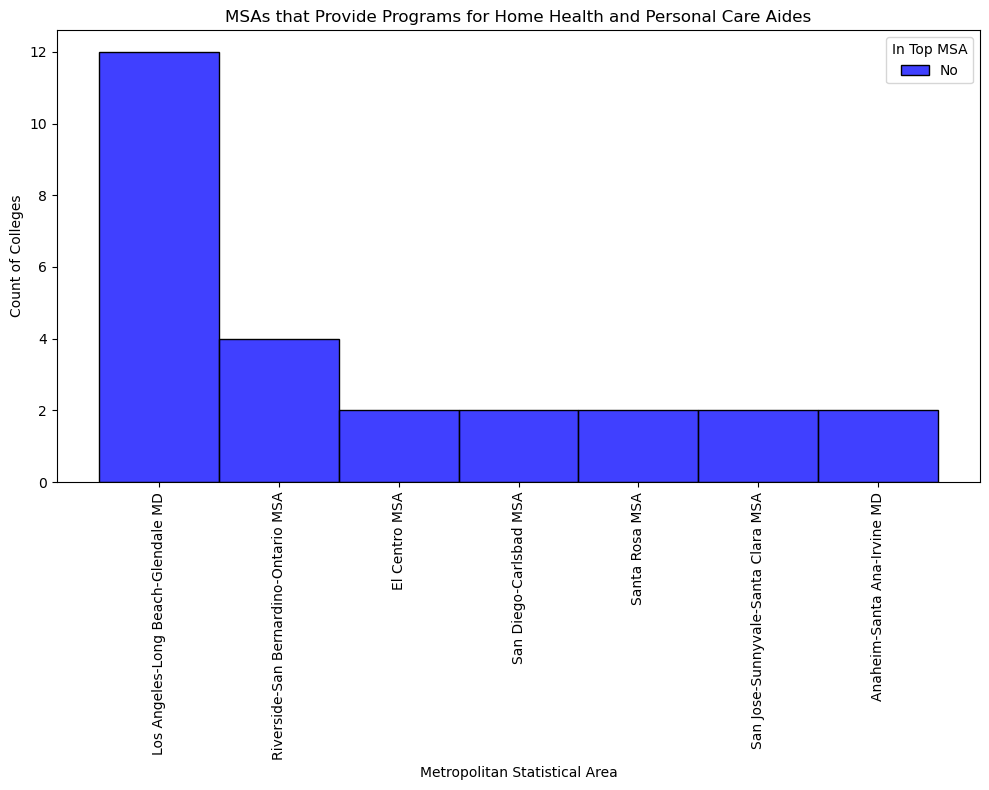

In [18]:
in_demand_areas = top_occupation_numeric_change[
    top_occupation_numeric_change["Standard Occupational Classification (SOC)"] == "31-1120"
]["Area Name"].unique()

msa_college_data["In Top MSA"] = msa_college_data["Metropolitan Statistical Area"].apply(
    lambda x: "Yes" if x in in_demand_areas else "No"
)
# Reorder the bars in descending order of size
msa_college_data["Metropolitan Statistical Area"] = pd.Categorical(
    msa_college_data["Metropolitan Statistical Area"],
    categories=msa_college_data["Metropolitan Statistical Area"].value_counts().index,
    ordered=True
)

plt.gcf().set_size_inches(10, 8)
# Plot the histogram
sns.histplot(
    data=msa_college_data, 
    x="Metropolitan Statistical Area", 
    hue="In Top MSA", 
    multiple="stack", 
    palette={"Yes": "green", "No": "blue"},
    discrete=True
)
plt.xticks(rotation=90)
plt.title("MSAs that Provide Programs for Home Health and Personal Care Aides")
plt.xlabel("Metropolitan Statistical Area")
plt.ylabel("Count of Colleges")
plt.tight_layout()
plt.savefig("figures/msa_in_demand.png")


Now we consider popular majors/programs vs labor market trends. According to DataMart, *psychology* is the most popular program, other than the *biological and physical sciences (and mathematics)* joint programs.

In [19]:
# Sorted by percent change.

psych_jobs = labor_market.get_occupation_projections_by_title("Psych")
psych_jobs.head()

,_id,_full_text,Area Type,Area Name,Period,SOC Level,Standard Occupational Classification (SOC),Occupational Title,Base Year Employment Estimate,Projected Year Employment Estimate,Numeric Change,Percentage Change,Exits,Transfers,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
0,3855,'-2030':10 '-3031':13 '0':27 '0.00':26 '100':2...,Metropolitan Area,Hanford-Corcoran MSA (Kings County),2020-2030,4,19-3031,"Clinical, Counseling, and School Psychologists",110.0,130.0,20.0,18.2,30.0,50.0,100.0,0.0,0.0,Doctoral or professional degree,None,Internship/residency
1,14771,'-2030':9 '-3031':12 '0':26 '0.00':25 '120':23...,Metropolitan Area,Santa Rosa MSA (Sonoma County),2020-2030,4,19-3031,"Clinical, Counseling, and School Psychologists",290.0,340.0,50.0,17.2,80.0,120.0,250.0,0.0,0.0,Doctoral or professional degree,None,Internship/residency
2,8769,'-2030':8 '-3031':11 '0':25 '0.00':24 '10':19 ...,Metropolitan Area,Redding MSA (Shasta County),2020-2030,4,19-3031,"Clinical, Counseling, and School Psychologists",60.0,70.0,10.0,16.7,20.0,30.0,60.0,0.0,0.0,Doctoral or professional degree,None,Internship/residency
3,15784,'-2030':10 '-3031':13 '0':27 '0.00':26 '100':2...,Metropolitan Area,Vallejo-Fairfield MSA (Solano County),2020-2030,4,19-3031,"Clinical, Counseling, and School Psychologists",240.0,280.0,40.0,16.7,70.0,100.0,210.0,0.0,0.0,Doctoral or professional degree,None,Internship/residency
4,11029,'-2030':12 '-3031':15 '0':29 '0.00':28 '15.3':...,Metropolitan Area,San Diego-Carlsbad MSA (San Diego County),2020-2030,4,19-3031,"Clinical, Counseling, and School Psychologists",1770.0,2040.0,270.0,15.3,500.0,750.0,1520.0,0.0,0.0,Doctoral or professional degree,None,Internship/residency


In [20]:
# Sorted by numeric change.

psych_jobs.sort_values(by="Numeric Change", ascending=False).head()

,_id,_full_text,Area Type,Area Name,Period,SOC Level,Standard Occupational Classification (SOC),Occupational Title,Base Year Employment Estimate,Projected Year Employment Estimate,Numeric Change,Percentage Change,Exits,Transfers,Total Job Openings,Median Hourly Wage,Median Annual Wage,Entry Level Education,Work Experience,Job Training
19,4287,'-2030':15 '-3031':18 '0':32 '0.00':31 '1310':...,Metropolitan Area,Los Angeles-Long Beach-Glendale MD (Los Angele...,2020-2030,4,19-3031,"Clinical, Counseling, and School Psychologists",4790.0,5260.0,470.0,9.8,1310.0,1960.0,3740.0,0.00,0.0,Doctoral or professional degree,None,Internship/residency
78,4479,'-2030':15 '-2053':18 '1240':26 '13.7':24 '202...,Metropolitan Area,Los Angeles-Long Beach-Glendale MD (Los Angele...,2020-2030,4,29-2053,Psychiatric Technicians,2710.0,3080.0,370.0,13.7,790.0,1240.0,2400.0,23.02,47876.0,Postsecondary non-degree award,Less than 5 years,Short-term on-the-job training
4,11029,'-2030':12 '-3031':15 '0':29 '0.00':28 '15.3':...,Metropolitan Area,San Diego-Carlsbad MSA (San Diego County),2020-2030,4,19-3031,"Clinical, Counseling, and School Psychologists",1770.0,2040.0,270.0,15.3,500.0,750.0,1520.0,0.00,0.0,Doctoral or professional degree,None,Internship/residency
68,4464,'-1223':18 '-2030':15 '0':28 '0.00':27 '14.4':...,Metropolitan Area,Los Angeles-Long Beach-Glendale MD (Los Angele...,2020-2030,4,29-1223,Psychiatrists,1600.0,1830.0,230.0,14.4,280.0,190.0,700.0,0.00,0.0,Doctoral or professional degree,None,Internship/residency
18,9225,'-2030':16 '-3031':19 '0':33 '0.00':32 '10.0':...,Metropolitan Area,Riverside-San Bernardino-Ontario MSA (Riversid...,2020-2030,4,19-3031,"Clinical, Counseling, and School Psychologists",2000.0,2200.0,200.0,10.0,550.0,820.0,1570.0,0.00,0.0,Doctoral or professional degree,None,Internship/residency


C:\Users\codyc\AppData\Local\Temp\ipykernel_18916\248909234.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


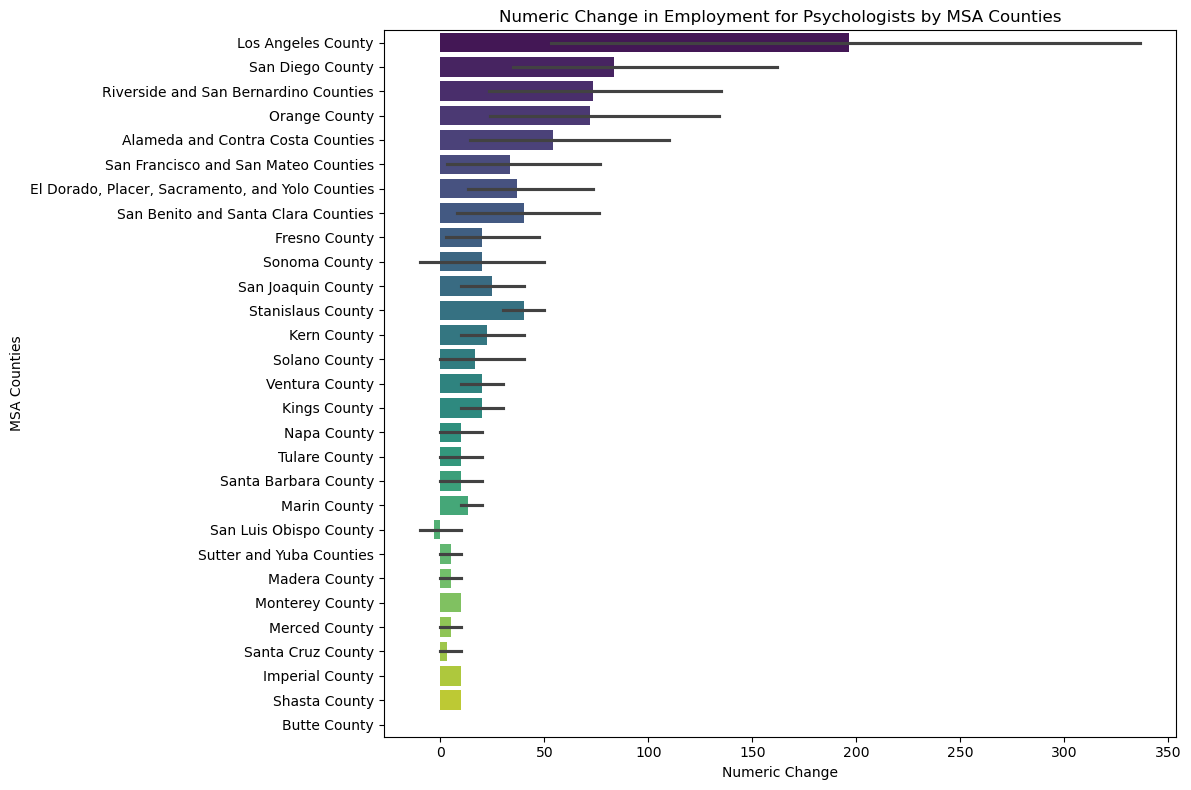

In [21]:
sorted_psych_jobs = psych_jobs.sort_values(by="Numeric Change", ascending=False)


sorted_psych_jobs = sorted_psych_jobs.merge(
    msa[["Area Name", "MSA Counties"]], on="Area Name", how="left"
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=sorted_psych_jobs,
    x="Numeric Change",
    y="MSA Counties",
    palette="viridis",
)
plt.title("Numeric Change in Employment for Psychologists by MSA Counties")
plt.xlabel("Numeric Change")
plt.ylabel("MSA Counties")
plt.tight_layout()
plt.savefig("figures/psychologist_employment.png")
plt.show()